# AirRaid-PPO implementation

PPO test in the AirRaid environment

In [7]:
import gym
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from keras import backend as K
from collections import deque
import random
from matplotlib import pyplot as plt
from threading import Thread

K.set_image_data_format('channels_first')

## Memory

Class used to memorize the trajectory and calculate the advntage

In [8]:
class Memory(object):
    
    STATE = 0
    ACTION = 1
    ACTION_PROB = 2
    REWARD = 3
    DONE = 4
    
    def __init__(self, n_trajectories, gamma = 0.98, lambda_p = 0.96):
        self.trajectories = np.empty(n_trajectories, dtype=object)
        self.gamma = gamma
        self.lambda_p = lambda_p
              
    def collect(self, state, action, action_prob, reward, done, i_episode):
        if (self.trajectories[i_episode] == None):
            self.trajectories[i_episode] = deque(maxlen=N_STEPS)
        self.trajectories[i_episode].append((state, action, action_prob, reward, done))
        
    def calculate_advantages(self):
        advantages = []
        TDerrors = [] #list of all the delta, used to uopdate the critic
        discounts = []
        
        for trajectory in self.trajectories:
            
            advantage_trajectory = [] #list of advantages for each element in a single trajectory
            delta = []
            G = []
            
            delta.append(trajectory[-2][self.REWARD] + self.gamma*ppo.return_v_values(trajectory[-1][self.STATE]) - ppo.return_v_values(trajectory[-2][self.STATE]) ) 
            old_advantage = delta[-1] 
            advantage_trajectory.append(old_advantage[0])
            G.append(trajectory[-2][self.REWARD] + self.gamma*ppo.return_v_values(trajectory[-1][self.STATE]))

            for i in range(len(trajectory)-3,-1,-1):
                delta.append(trajectory[i+1][self.REWARD] + self.gamma*ppo.return_v_values(trajectory[i+1][self.STATE]) - ppo.return_v_values(trajectory[i][self.STATE]))
                G.append(trajectory[i][self.REWARD] + self.gamma*G[-1])
                new_advantage = delta[-1] + self.gamma*self.lambda_p*old_advantage

                advantage_trajectory.append(new_advantage[0])   

                old_advantage = new_advantage

            advantages.append(advantage_trajectory)
            TDerrors.append(delta)
            discounts.append(G)
            
        #flat all trajectories in a single deque adding the advantages (easier to sample random batches)
        self.flat_trajectories(advantages, TDerrors, discounts)
    
    def flat_trajectories(self, advantages, TDerrors, G):
        
        size = 0
        for trajectory in self.trajectories:
            size = size + len(trajectory)
        self.flatten_trajectories = deque(maxlen=size)
        
        for trajectory, advantage, delta, discount in zip(self.trajectories, advantages, TDerrors, G):
            for i in range(len(trajectory)-2, -1, -1):
                self.flatten_trajectories.append((trajectory[i][self.STATE], 
                                                  trajectory[i][self.ACTION], 
                                                  trajectory[i][self.ACTION_PROB], 
                                                  trajectory[i][self.REWARD], 
                                                  advantage[len(trajectory)-2-i], #they are reversed in respect to the trajectory
                                                  delta[len(trajectory)-2-i],
                                                  discount[len(trajectory)-2-i],
                                                  trajectory[i][self.DONE]))
                #if (trajectory[i][self.DONE]):
                #    print("================================================")
                #print("{}. v: {} G: {}".format(i, ppo.return_v_values(trajectory[i][self.STATE]), discount[len(trajectory)-2-i]))
                #print("Action {}".format(trajectory[i][self.ACTION]))
                #print("Action Prob {}".format(trajectory[i][self.ACTION_PROB]))
                #print("Advantage {}".format(advantage[len(trajectory)-2-i]))
                #print("Delta {}".format(delta[len(trajectory)-2-i]))
        
        
    #pick a random batch example from the flatten list of trajectories
    def sample_experiences(self, batch_size):
        if (len(self.flatten_trajectories) >= batch_size):
            indices = np.random.permutation(len(self.flatten_trajectories))[:batch_size]
        else:
            indices = np.random.permutation(len(self.flatten_trajectories))
        batch = [self.flatten_trajectories[index] for index in indices]
        #delete form the memory the used obervations
        for index in sorted(indices, reverse=True):
            del self.flatten_trajectories[index]
        states, actions, actions_prob, rewards, advantages, TDerrors, discounts, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(8)]
        return states, actions, actions_prob, rewards, advantages, TDerrors, discounts, dones
        
    def reset(self):
        for trajectory in self.trajectories:
            trajectory.clear()
        self.flatten_trajectories.clear()

# PPO class

$ s_{t+1} $ is the observed state after the current action $ a_t $ 

Actor update formula:
$ \theta_{t+1} = \theta_t + \alpha\nabla min(r_t(\theta)\hat{A}_t, clip(r_t(\theta),1-\epsilon,1+\epsilon)\hat{A}_t)$

Critic update formula:
$ w_{t+1} = w_t + \alpha G_t\nabla\hat{v}(s_t,w)$

Probability ratio $ r_t(\theta) \doteq $
$ \pi_\theta(a_t | s_t) \over \pi_{\theta_old}(a_t | s_t) $

Advantage:
$ \hat{A}_t \doteq \delta_t + (\gamma\lambda)\delta_{t+1} + (\gamma\lambda)^2\delta_{t+2} + ... + (\gamma\lambda)^{T-t+1}\delta_{T-1} = \delta_t + (\gamma\lambda)\hat{A}_{t+1}$

TDerror:
$ \quad \delta_t  \doteq $
$ G_t - \hat{v}(s_t,w) $ $ \qquad $ (if $ s_{t+1} $ is terminal then $ \hat{v}(s_{t+1},w) = 0$)

Discounted return:
$ G_t \doteq $
$ r_t + \gamma\hat{v}(s_{t+1},w) $

In [9]:
class PPO(object):
    
    input_shape = [4,84,84] 
    n_outputs = 4 #stack_env.action_space.n
    
    next_reward = 0
    
    def __init__(self, n_episodes = 1, train_steps = 100, epsilon = 0.2, alpha = 1):
        self.actor = self.create_actor()
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
        
        self.critic = self.create_critic()
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        
        self.epsilon = epsilon
        self.alpha = alpha
        
        self.train_steps = train_steps
        
        self.memory = Memory(n_episodes)
        
    #create the NN of the actor
    # Given the state returns the probability of each action
    def create_actor(self):
        initializer = tf.keras.initializers.GlorotNormal()
        actor = keras.Sequential([
            keras.layers.Conv2D(filters=32, kernel_size = (8,8), strides=4, activation="tanh", input_shape = self.input_shape, kernel_initializer=initializer),
            keras.layers.Conv2D(filters=64, kernel_size = (4,4), strides=2, activation="tanh", kernel_initializer=initializer),
            keras.layers.Conv2D(filters=64, kernel_size = (3,3), strides=1, activation="tanh", kernel_initializer=initializer),
            keras.layers.Dense(512, kernel_initializer=initializer),
            keras.layers.Dropout(0.3),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(self.n_outputs, kernel_initializer=initializer, activation = 'softmax') ])
        return actor
       
    #create the NN of the critic
    # Given the state returns the value function
    def create_critic(self):
        critic = keras.Sequential([
            keras.layers.Conv2D(filters=32, kernel_size = (8,8), strides=4, activation="relu", input_shape = self.input_shape),
            keras.layers.Conv2D(filters=64, kernel_size = (4,4), strides=2, activation="relu"),
            keras.layers.Conv2D(filters=64, kernel_size = (3,3), strides=1, activation="relu"),
            keras.layers.Dense(512),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(1) ])
        
        self.critic_loss_fn = tf.keras.losses.mean_squared_error
        
        return critic
      
    def play_one_step(self, env, observation, i_episode):
        action, action_prob = self.select_action(observation)
        past_reward = self.next_reward
        next_observation, self.next_reward, done, info = env.step(action)
        
        #self.next_reward = ((float) self.next_reward) / 100
        
        self.memory.collect(observation, action, action_prob, past_reward, done, i_episode)
        if (done):
            self.memory.collect(next_observation, action, action_prob, self.next_reward, done, i_episode)
            
        return next_observation, action, past_reward, done, info
        
    #select the action
    def select_action(self, observation):
        
        action_probabilities = self.actor.predict(tf.expand_dims(np.array(observation) / 255, axis=0))[0]
        action = np.random.choice(a = len(action_probabilities), p = action_probabilities)
        
        return action, action_probabilities[action]
    
    def train(self, batch_size):
        self.memory.calculate_advantages()
        
        for i_step in range(self.train_steps):
            done = self.training_step(batch_size)
            if (done):
                break
        
        self.memory.reset()
        
    #training done on the memory (the advantages must be calculated before hand)
    def training_step(self, batch_size):
        #get experiences (parts of a trajectory) from the memory
        states, actions, actions_prob, rewards, advantages, TDerrors, discounts, dones = self.memory.sample_experiences(batch_size)
        
        done = False
        if (len(states) == 0):
            return True
        if (len(states) != batch_size):
            done = True
        
        #compute the values for the update of the actor
        
        mask = tf.one_hot(actions, self.n_outputs)

        states = np.array(states) / 255
        #array of shape (64,) into array of shape (64,1)
        #states =  np.array(np.array_split(states, len(states)))
        
        with tf.GradientTape() as tape:
            current_actions_prob = self.actor(states)
            
            current_action_prob = tf.reduce_sum(current_actions_prob*mask, axis=1, keepdims=True)
            old_actions_prob = tf.reshape(tf.convert_to_tensor(actions_prob), [len(states), 1])
            probability_ratio = tf.divide(tf.math.log(current_action_prob + 1e-7), tf.math.log(old_actions_prob + 1e-7 ))
        
            #sobtitute nan values with zero (where given an array of True/false puy the element of the first array (tf.zeros_like(probability_ratio)) in the position where is True, the second (probability_ratio) where is False)
            probability_ratio = tf.where(tf.math.is_nan(probability_ratio), tf.zeros_like(probability_ratio), probability_ratio)
        
            surrogate_arg_1 = tf.convert_to_tensor([probability_ratio[index]*advantages[index] for index in range(len(advantages))])
            surrogate_arg_2 = tf.convert_to_tensor(np.array([tf.keras.backend.clip(probability_ratio,1-self.epsilon,1+self.epsilon)[index]*advantages[index] for index in range(len(advantages))]).flatten())
            
            L = 0 - tf.minimum( surrogate_arg_1 , surrogate_arg_2 ) 
            loss = tf.reduce_mean(L)

        actor_weights = self.actor.trainable_variables
        grads = tape.gradient(loss, actor_weights)
        self.actor_optimizer.apply_gradients(zip(grads, actor_weights))
        
        #update of the critic. The target is Gt
        target_v_values = tf.reshape(tf.convert_to_tensor(np.asarray(self.alpha*discounts).astype('float32')), (len(states), 1))

        with tf.GradientTape() as tape:
            v_values = self.critic(states)
            loss = tf.reduce_mean(self.critic_loss_fn(target_v_values, v_values))
        grads = tape.gradient(loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))
        
        return done
    
    def return_v_values(self, observation):
        v = self.critic.predict(tf.expand_dims(np.array(observation) / 255, axis=0))[0]
        return v
    
    def save(self, path = ".\\saved_weights\\ppo\\"):
        self.actor.save_weights(path + 'actor_weights.h5')
        self.critic.save_weights(path + 'critic_weights.h5')
        
    def load(self, path = ".\\saved_weights\\ppo\\"):
        self.actor.load_weights(path + 'actor_weights.h5')
        self.critic.load_weights(path + 'critic_weights.h5')

## Training

In [10]:
class collect_trajectory(Thread):
    
    def __init__(self, environment, i_agent, env):
         
        Thread.__init__(self)   
        self.n_agent = i_agent
        self.rewards = [] 
        
        self.env = env
        
    def run(self):
        
        observation = self.env.reset()
        past_lifes = 5 #info['ale.lives']
        
        self.env.step(1)
        
        self.episode_reward = 0.0
        
        for i_step in range(N_STEPS):   
            observation, action, reward, done, info = ppo.play_one_step(self.env, observation, self.n_agent)

            current_lifes = info['ale.lives']
    
            if (current_lifes <= past_lifes):
                past_lifes = current_lifes
                observation, reward, done, info = self.env.step(1)
            
            self.episode_reward = self.episode_reward + reward
            
            #continuing task. if an episode is done we continue until complting the number of steps
            if (done):
                break
        
        self.env.close()
        
        print("Exiting {} afte n. steps {}. Tot reward: {}".format(self.n_agent, i_step, self.episode_reward))
    
    def get_reward(self):
        return self.episode_reward

In [13]:
N_EPOCHS = 100
N_EPISODES = 16 # in multi-agent this is the number of agents (each agnet collect 1 trajectory)
N_STEPS = 200 # max number of step for each episode

TRAIN_STEPS = 50 # number of max steps done during training. if the number of samples is less than TRAIN_STEPS*BATCH_SIZE will stop early after completing the training on all the samples
BATCH_SIZE = 128

#env used to initialize the parameters inside PPO and RND
environment = "BreakoutNoFrameskip-v4" # "AirRaidNoFrameskip-v4", "GravitarFrameskip-v4"

ppo = PPO(n_episodes = N_EPISODES, train_steps = TRAIN_STEPS)

rewards = []

envs = []

for i_env in range(N_EPISODES):
        basic_env = gym.make(environment, obs_type = "image")
        wrapped_env = AtariPreprocessing(basic_env)
        envs.append(FrameStack(wrapped_env, 4))

highest_average_reward = 0
        
for i_epoch in range(N_EPOCHS):
    epoch_reward = 0.0
    agents = []
    for i_agent in range(N_EPISODES):
        agents.append(collect_trajectory(environment = environment, i_agent = i_agent, env = envs[i_agent]))
    for agent in agents:
        agent.start()
    for agent in agents:
        agent.join()
        agent_reward = agent.get_reward()
        epoch_reward = epoch_reward + agent_reward
    rewards.append(epoch_reward/N_EPISODES)
    print("Epoch: {} ended with average reward: {}\n".format(i_epoch, epoch_reward/N_EPISODES))  
    
    if (highest_average_reward <= rewards[-1]):
        highest_average_reward = rewards[-1]
        ppo.save()
        
    ppo.train(batch_size = BATCH_SIZE)
    
for i_env in range(N_EPISODES):
    envs[i_env].close()

Exiting 10 afte n. steps 60. Tot reward: 0.0
Exiting 6 afte n. steps 60. Tot reward: 0.0
Exiting 8 afte n. steps 74. Tot reward: 1.0
Exiting 9 afte n. steps 74. Tot reward: 0.0
Exiting 1 afte n. steps 60. Tot reward: 0.0
Exiting 12 afte n. steps 83. Tot reward: 1.0
Exiting 0 afte n. steps 74. Tot reward: 0.0
Exiting 2 afte n. steps 74. Tot reward: 1.0
Exiting 14 afte n. steps 83. Tot reward: 1.0
Exiting 5 afte n. steps 89. Tot reward: 1.0
Exiting 7 afte n. steps 97. Tot reward: 1.0
Exiting 4 afte n. steps 97. Tot reward: 1.0
Exiting 15 afte n. steps 97. Tot reward: 1.0
Exiting 3 afte n. steps 118. Tot reward: 2.0
Exiting 13 afte n. steps 132. Tot reward: 2.0
Exiting 11 afte n. steps 112. Tot reward: 2.0
Epoch: 0 ended with average reward: 0.875

Exiting 14 afte n. steps 60. Tot reward: 0.0
Exiting 7 afte n. steps 60. Tot reward: 0.0
Exiting 9 afte n. steps 60. Tot reward: 0.0
Exiting 4 afte n. steps 60. Tot reward: 0.0
Exiting 5 afte n. steps 60. Tot reward: 0.0
Exiting 13 afte n. step

Exiting 11 afte n. steps 106. Tot reward: 1.0
Epoch: 10 ended with average reward: 1.0

Exiting 1 afte n. steps 74. Tot reward: 1.0
Exiting 2 afte n. steps 74. Tot reward: 1.0
Exiting 14 afte n. steps 74. Tot reward: 1.0
Exiting 0 afte n. steps 74. Tot reward: 1.0
Exiting 11 afte n. steps 74. Tot reward: 1.0
Exiting 3 afte n. steps 74. Tot reward: 1.0
Exiting 13 afte n. steps 74. Tot reward: 1.0
Exiting 12 afte n. steps 74. Tot reward: 1.0
Exiting 8 afte n. steps 90. Tot reward: 1.0
Exiting 6 afte n. steps 74. Tot reward: 1.0
Exiting 7 afte n. steps 90. Tot reward: 1.0
Exiting 10 afte n. steps 106. Tot reward: 1.0
Exiting 4 afte n. steps 106. Tot reward: 1.0
Exiting 9 afte n. steps 106. Tot reward: 1.0
Exiting 5 afte n. steps 106. Tot reward: 1.0
Exiting 15 afte n. steps 106. Tot reward: 1.0
Epoch: 11 ended with average reward: 1.0

Exiting 2 afte n. steps 90. Tot reward: 1.0
Exiting 5 afte n. steps 74. Tot reward: 1.0
Exiting 9 afte n. steps 74. Tot reward: 1.0
Exiting 4 afte n. steps

KeyboardInterrupt: 

In [14]:
basic_env = gym.make("BreakoutNoFrameskip-v4", obs_type = "image")
wrapped_env = AtariPreprocessing(basic_env)
stack_env = FrameStack(wrapped_env, 4)

#ppo = PPO()

#ppo.load()

observation = stack_env.reset()
observation, reward, done, info = stack_env.step(1)

past_lifes = info['ale.lives']

print(observation)
print("Starting demo")
for i_step in range(300):   
    
    action, action_prob = ppo.select_action(observation)
    
    observation, reward, done, info = stack_env.step(action)
    
    current_lifes = info['ale.lives']
    
    if (current_lifes <= past_lifes):
        past_lifes = current_lifes
        observation, reward, done, info = stack_env.step(1)
    
    #rand_action = stack_env.action_space.sample()
    #observation, reward, done, info = stack_env.step(rand_action)
    print("step {} selected action {} with prob {} got reward {}".format(i_step, action, action_prob, reward))

    stack_env.render()
            
    if (done):
        break
        
stack_env.close()

Starting demo
step 0 selected action 3 with prob 1.0 got reward 0.0
step 1 selected action 3 with prob 1.0 got reward 0.0
step 2 selected action 3 with prob 1.0 got reward 0.0
step 3 selected action 3 with prob 1.0 got reward 0.0
step 4 selected action 3 with prob 1.0 got reward 0.0
step 5 selected action 3 with prob 1.0 got reward 0.0
step 6 selected action 3 with prob 1.0 got reward 0.0
step 7 selected action 3 with prob 1.0 got reward 0.0
step 8 selected action 3 with prob 1.0 got reward 0.0
step 9 selected action 3 with prob 1.0 got reward 0.0
step 10 selected action 3 with prob 1.0 got reward 0.0
step 11 selected action 3 with prob 1.0 got reward 0.0
step 12 selected action 3 with prob 1.0 got reward 0.0
step 13 selected action 3 with prob 1.0 got reward 0.0
step 14 selected action 3 with prob 1.0 got reward 0.0
step 15 selected action 3 with prob 1.0 got reward 0.0
step 16 selected action 3 with prob 1.0 got reward 0.0
step 17 selected action 3 with prob 1.0 got reward 0.0
step 1

## Plot graph

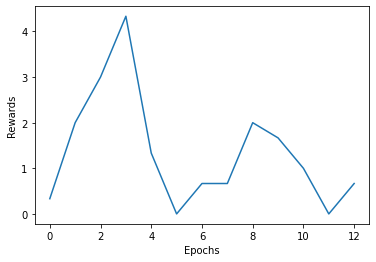

In [7]:
epochs = range(13)#N_EPOCHS)

plt.plot(epochs, rewards)

plt.xlabel("Epochs")
plt.ylabel("Rewards")

plt.show()